# Gabriel Graph from a Delaunay Tessellation in Scipy

The [Gabriel graph](https://en.wikipedia.org/wiki/Gabriel_graph) is a subset of the [Delaunay graph](https://en.wikipedia.org/wiki/Delaunay_triangulation). The following code attempts to leverage this fact by using Scipy's built-in [Delaunay class](https://docs.scipy.org/doc/scipy-1.0.0/reference/generated/scipy.spatial.Delaunay.html) in the [spatial module](https://docs.scipy.org/doc/scipy-1.0.0/reference/spatial.html), then pruning the non-Gabriel edges.

In [2]:
import numpy as np
import scipy as sp
from scipy import spatial
from scipy import sparse
from matplotlib import pyplot as plt

## Generate Delaunay Tessellation
Start by generating a set of random points, then pass them to ``scipy.spatial.Delaunay``:

In [3]:
pts = np.random.rand(200, 2)  # To make 3D points just use sp.rand(200, 3)
tri = spatial.Delaunay(points=pts)

Convert ``tri`` to a standard adjacency matrix, which is much easier to work with, especially for vectorized operations:

In [4]:
# Create an empty list-of-list matrix which allows building by row
lil = sparse.lil_matrix((tri.npoints, tri.npoints))
# Scan through Delaunay triangulation to retrieve pairs
indptr, indices = tri.vertex_neighbor_vertices
for k in range(tri.npoints):
    lil.rows[k] = indices[indptr[k]:indptr[k+1]].tolist()
    lil.data[k] = np.ones_like(lil.rows[k]).tolist()  # dummy data of same shape as row
# Convert to coo format for direct access to each node-edge-node pair
coo = lil.tocoo()
# conns contains the index of 2 nodes at each end of an edge
conns = np.vstack((coo.row, coo.col)).T
# Convert to upper triangular
delaunay_conns = np.sort(conns, axis=1)

``delaunay_conns`` is the adjacency matrix for the Delanauy triangulation in the [COO sparse format](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html), so that each row contains the (row, col) location on a non-zero element.  Since we only care about connections, not the weights of the connections, we ignore the ``coo.data`` attribute.

## Trim Edges from Delaunay tessellation to get Gabriel graph
The Gabriel network is a subset of the Delaunay, so we just need to prune non-Gabriel edges.  A connection between two points is considered a Gabriel egde if you can connect the points by a circle, and that circle contains no other points. 

The following code performs this check for each edge in the Delanay tessellation by finding the midpoint of the edge, calculating the radius of the circle centered on that midpoint, then finding if any points are within that radius.  If yes, then that edge is NOT a Gabriel edge.

In [5]:
# Find centroid or midpoint of each edge in conns
c = tri.points[delaunay_conns]
m = (c[:, 0, :] + c[:, 1, :])/2
# Find the radius sphere between each pair of nodes
r = np.sqrt(np.sum((c[:, 0, :] - c[:, 1, :])**2, axis=1))/2

In order to see if any of the base points are closer to a given midpoint than ``r``, we'll use scipy's [KDTree class](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html).  This class uses a fancy data structure that allows for efficient searching of nearest neighbors.  We will create a KDTree of the base points, then ``query`` the tree to find the distance of the nearest basepoint for each midpoint in ``m``.  

In [6]:
# Use the kd-tree function in Scipy's spatial module
tree = spatial.cKDTree(pts)
# Find the nearest point for each midpoint
n = tree.query(x=m, k=1)[0]
# If nearest point to m is at a distance r, then the edge is a Gabriel edge
g = n >= r*(0.999)  # The factor is to avoid precision errors in the distances
# Reduce the connectivity to all True values found in g
gabriel_conns = delaunay_conns[g]

Create a little function for plotting the connections between the nodes or points:

In [15]:
def plot_conns(conns, pts, fig=None, **kwargs):
    if fig is None:
        fig = plt.figure()
    # Use of mind-bending indexing to plot line segments in a vectorized way
    i = -np.ones(shape=(conns.shape[0]*3, ), dtype=int)
    i[0::3] = conns[:, 0]
    i[1::3] = conns[:, 1]
    # Add sp.inf to the last element of pts (to trick Matplotlib)
    pts = np.vstack((pts, [np.inf, np.inf]))
    X, Y = [pts[:, 0], pts[:, 1]]
    plt.plot(X[i], Y[i], **kwargs)
    return fig

Now, we can inspect the results by plotting each graph on top of each other.  As can be seen, the Grabiel graph (in red) is a subset of the Delaunay graph (in pale blue).

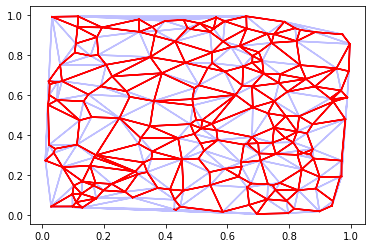

In [16]:
fig = plot_conns(conns=delaunay_conns, pts=pts, color='b', alpha=0.25)
fig = plot_conns(conns=gabriel_conns, pts=pts, color='r', fig=fig)

In [21]:
i = -np.ones(shape=(gabriel_conns.shape[0]*3, ), dtype=int)

In [22]:
i[0::3] = gabriel_conns[:, 0]
i[1::3] = gabriel_conns[:, 1]

In [23]:
i

array([  0, 181,  -1, ..., 192, 199,  -1])